## Intializing stuff

In [1]:
!pwd

/user/m44/ondemand/cse546-rl/assignment1


In [2]:
!which python

/projects/academic/courses/cse546s23/m44/anaconda3/bin/python


In [3]:
import pygame
import numpy as np
from gymnasium import Env
from gymnasium import spaces
import matplotlib.pyplot as plt

pygame 2.1.2 (SDL 2.0.16, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Display set up
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


os.environ["SDL_VIDEODRIVER"] = "dummy"

## Build Determinisitic Grid Env

### Rules:
- Each square has a randomly assigned reward between -0.75 to 0.75.
- The size of the cactus/lemonade is indicative of the reward.
- Landing on a square causes the reward on that square to be consumed. i.e. landing on that square again will yield no reward (0 reward).

In [5]:
class DeterministicGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./background.jpg",
        "goal_img": "./goal.png",
        "agent_img": "./agent.png",
        "reward_img": "./reward.png",
        "neg_reward_img": "./neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None
    ):
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), dtype=int),
            }
        )
        self.observation_space['agent'].sample()
        self.observation_space['goal'].sample()

        self.action_space = spaces.Discrete(4)
        self.max_timesteps = max_time_steps

        # Randomly distribute rewards between -0.75 to 0.75
        self._base_state = self.np_random.uniform(
            -.75, .75, size=(self.size, self.size)
        )
        np.around(self._base_state, 2, self._base_state)

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }

        self.timestep = 0
        self._agent_pos = self.observation_space['agent'].sample()
        self._goal_pos = self._agent_pos.copy()

        # We will sample the goal's location randomly until it does not coincide
        # with the agent's location
        while np.array_equal(self._goal_pos, self._agent_pos):
            self._goal_pos = self.observation_space['goal'].sample()

        self.state = self._base_state.copy()
        self.state[tuple(self._goal_pos)] = 1. # Max Reward
        self.state[tuple(self._agent_pos)] = 0. # 0 reward at start

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.state = self._base_state.copy()

        # Agent start pos changes everytime
        while np.array_equal(self._goal_pos, self._agent_pos):
            self._agent_pos = self.observation_space['agent'].sample()

        self.state[tuple(self._goal_pos)] = 1. # Max Reward
        self.state[tuple(self._agent_pos)] = 0. # 0 reward at start

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        direction = self._action_to_direction[action]['move']
        
        # Restricting the agent to the grid.
        self._agent_pos = np.clip(
            self._agent_pos + direction, 0, self.size - 1
        )

        # Record the action taken
        observation = self._get_obs()
        observation.update({
            'action': self._action_to_direction[action]['name'] 
        })
        
        reward = self.state[tuple(self._agent_pos)]

        # Consume reward
        self.state[tuple(self._agent_pos)] = 0        
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1
        terminated = np.array_equal(self._agent_pos, self._goal_pos)

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {"agent": self._agent_pos, "goal": self._goal_pos}

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.state[x, y]
                if self.state[x, y] > 0 and self.state[x, y] < 1:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.state[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [6]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return self.env.action_space.sample()

## Take the env for a spin

In [7]:
# Initialize the agent and the env
denv = DeterministicGridEnvironment(size=6, render_mode='rgb_array')
agent = RandomAgent(denv)

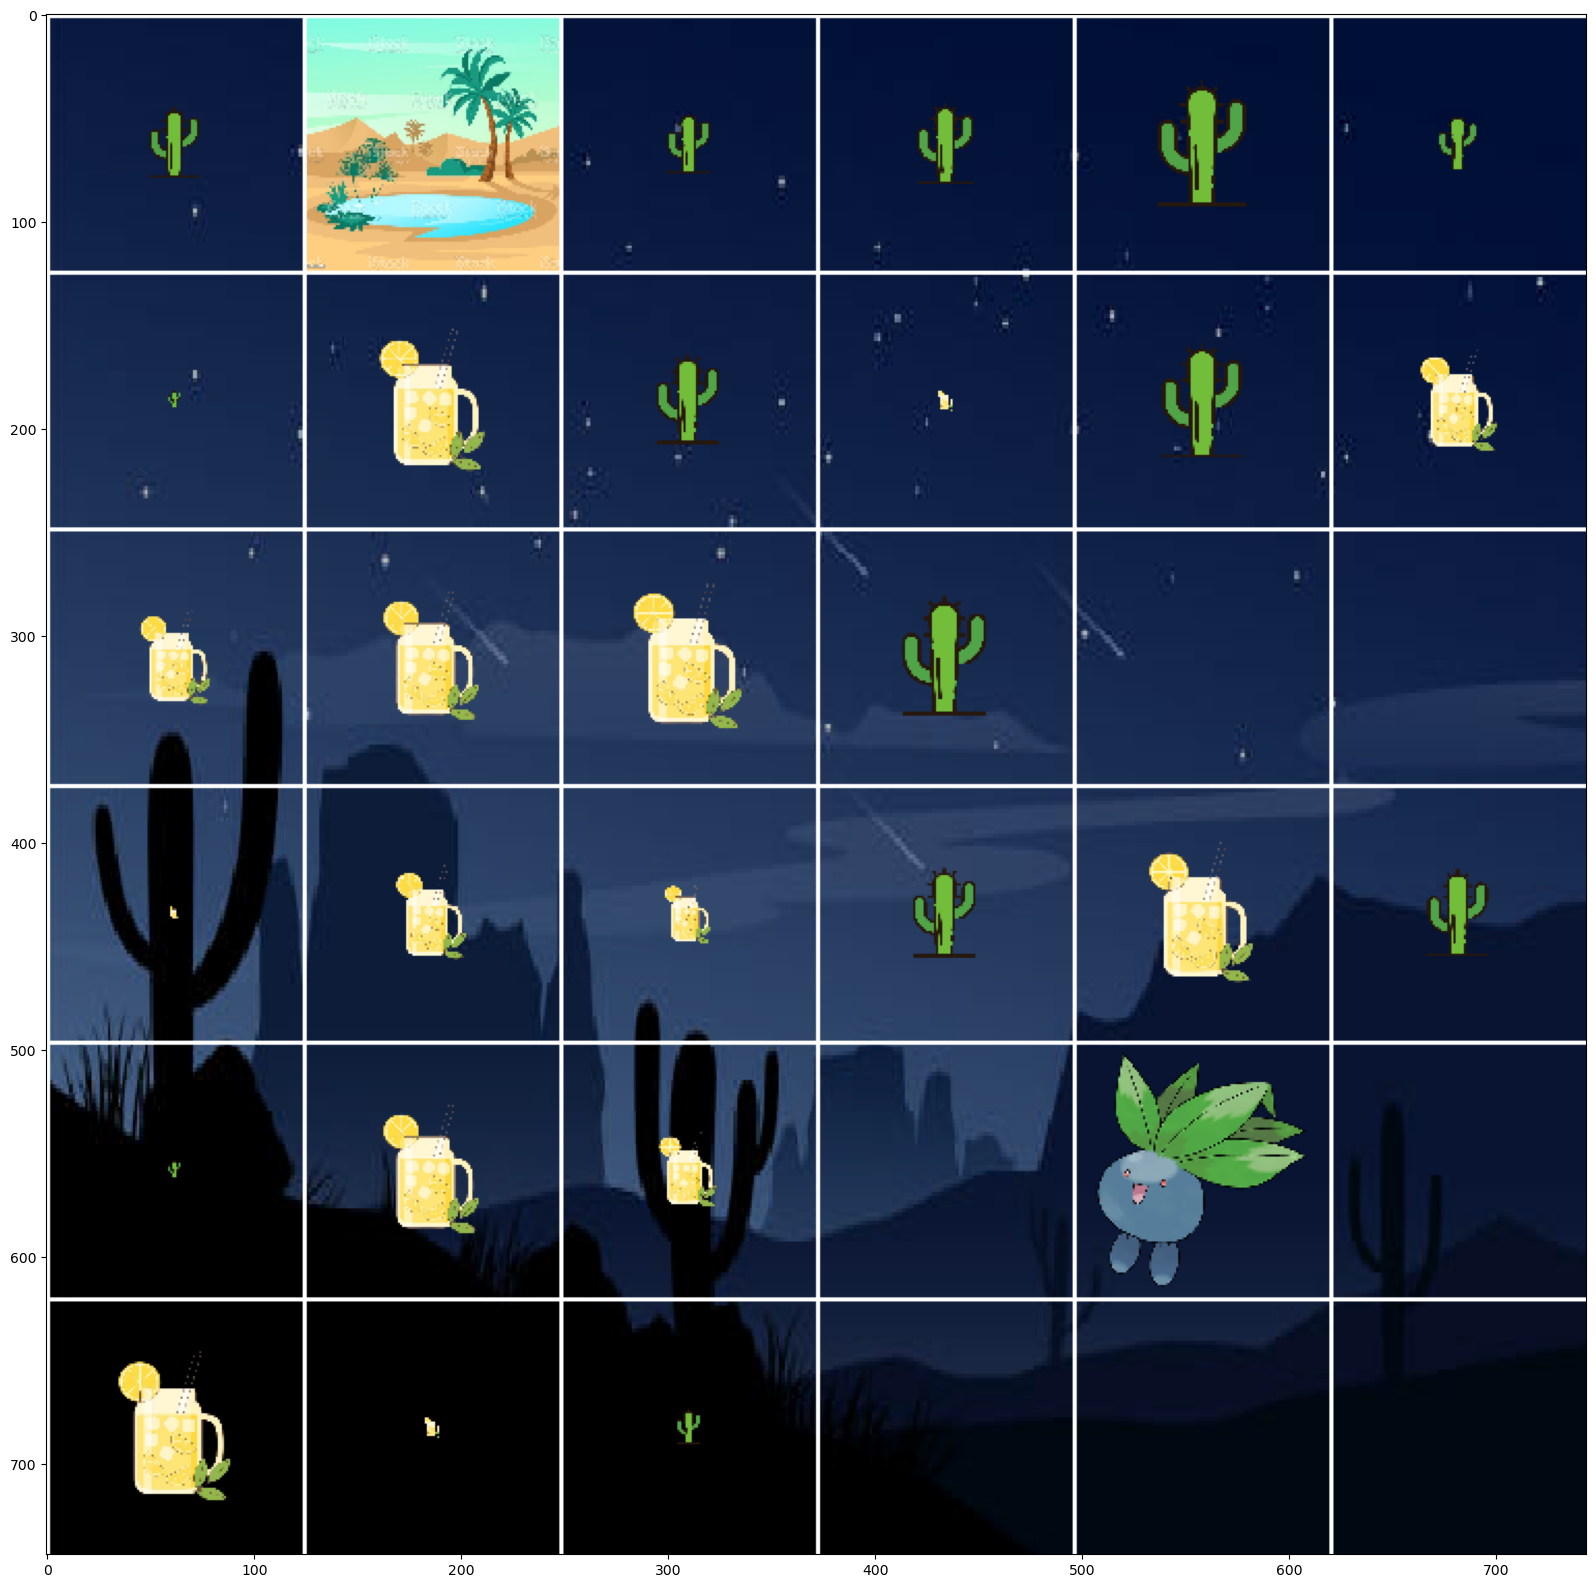

In [8]:
plt.rcParams["figure.figsize"] = (20,20)

obs, info = denv.reset(seed=88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

history = [obs]
while not (terminated or truncated):
  action = agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  history.append((obs, reward))
  time.sleep(1)


In [9]:
# End the simulation
for item in history:
    print(item)

denv.close()

{'agent': array([5, 3]), 'goal': array([0, 1])}
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'right'}, -0.44)
({'agent': array([5, 3]), 'goal': array([0, 1]), 'action': 'left'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'right'}, 0.0)
({'agent': array([4, 4]), 'goal': array([0, 1]), 'action': 'up'}, -0.08)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 5]), 'goal': array([0, 1]), 'action': 'right'}, -0.13)
({'agent': array([4, 5]), 'goal': array([0, 1]), 'action': 'up'}, -0.27)
({'agent': array([4, 5]), 'goal': array([0, 1]), 'action': 'right'}, 0.0)
({'agent': array([5, 5]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 5]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'left'}, 

## Build a Stocastic Grid Env

### Rules:
- Landing on a square causes the reward on that square to be consumed. i.e. landing on that square again will yield no reward (0 reward).
- Whenever you perform an action there is a 2/3rd chance that the action is as you expect it to be, a 2/9th chance that it is the double of what you want it to be and a 1/9th chance of it being a mirror action.
- The reward (and negative reward) for each state is distributed in a reciprocal fashion. i.e. 1/9th the reward when coming through the expected action, 2/9th reward when coming via the opposite action and 2/3rd reward when coming via a mirror action. 

For instance on a 5x5 grid where the reward on each square is 1 (for simplicity):

If `s = (2,3)` and `a = RIGHT`:
-   2/3rd chance `s' = (2,4)` and `r = 1/9`
-   2/9th chance `s' = (2,5)` and `r = 2/9`
-   2/3rd chance `s' = (3,2)` and `r = 2/3`

Exception: Landing on the `goal` square will always yield a maximal reward (of 1 for the above example) regardless of how you get there.

In [10]:
class StocasticGridEnvironment(Env):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
        "background_img": "./assets/background.jpg",
        "goal_img": "./assets/goal.png",
        "agent_img": "./assets/agent.png",
        "reward_img": "./assets/reward.png",
        "neg_reward_img": "./assets/neg_reward.png" 
    }

    def __init__(
        self,
        size: int = 4,
        max_time_steps:int = 20,
        render_mode=None
    ):
        self.size = size
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2, ), dtype=int),
                "goal": spaces.Box(0, size - 1, shape=(2, ), dtype=int),
            }
        )
        self.observation_space['agent'].sample()
        self.observation_space['goal'].sample()

        self.action_space = spaces.Discrete(4)
        self.action_mode_space = spaces.Discrete(3)
        self.max_timesteps = max_time_steps

        # Randomly distribute rewards between -0.75 to 0.75
        self._base_state = self.np_random.uniform(
            -.75, .75, size=(self.size, self.size)
        )
        np.around(self._base_state, 2, self._base_state)

        """The following dictionary maps abstract actions from `self.action_space` to
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: {'move': np.array([1, 0]), 'name': 'down'},
            1: {'move': np.array([-1, 0]), 'name': 'up'},
            2: {'move': np.array([0, 1]), 'name': 'right'},
            3: {'move': np.array([0, -1]), 'name': 'left'},
        }
        self._action_mode_mapping = {
            0: {'p': 2/3, 'name': 'as-is', 'score_mul': 1/9},
            1: {'p': 2/9, 'name': 'double', 'score_mul': 2/9},
            2: {'p': 1/9, 'name': 'mirror', 'score_mul': 2/3}
        }

        self.timestep = 0
        self._agent_pos = self.observation_space['agent'].sample()
        self._goal_pos = self._agent_pos.copy()

        # We will sample the goal's location randomly until it does not coincide
        # with the agent's location
        while np.array_equal(self._goal_pos, self._agent_pos):
            self._goal_pos = self.observation_space['goal'].sample()

        self.state = self._base_state.copy()
        self.state[tuple(self._goal_pos)] = 1. # Max Reward
        self.state[tuple(self._agent_pos)] = 0. # 0 reward at start

        # Check for render mode legality
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None
        self.window_size = 744  # The size of the PyGame window


    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        # Reset env
        self.timestep = 0
        self.state = self._base_state.copy()

        # Agent start pos changes everytime
        while np.array_equal(self._goal_pos, self._agent_pos):
            self._agent_pos = self.observation_space['agent'].sample()

        self.state[tuple(self._goal_pos)] = 1. # Max Reward
        self.state[tuple(self._agent_pos)] = 0. # 0 reward at start

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Randomly select the action mode
        action_mode = self.np_random.choice(
            range(self.action_mode_space.n),
            p=[self._action_mode_mapping[i]['p']
               for i in range(self.action_mode_space.n)]
        )

        if self._action_mode_mapping[action_mode]['name'] in ('opposite', 'as-is'):
            direction = self._action_to_direction[action]['move'].copy()
            if self._action_mode_mapping[action_mode]['name'] == 'opposite':
                direction *= 2

            # Restricting the agent to the grid.
            self._agent_pos = np.clip(
                self._agent_pos + direction, 0, self.size - 1
            )

        else:
            self._agent_pos = self._agent_pos[::-1]

        # Record the action taken
        observation = self._get_obs()
        observation.update({
            'action': self._action_to_direction[action]['name'],
            'action_mode': self._action_mode_mapping[action_mode]['name']
        })

        # Check if terminated
        if np.array_equal(self._agent_pos, self._goal_pos):
            reward = 1.
            terminated = True

        else:
            reward = np.round(self.state[tuple(self._agent_pos)] * 
                self._action_mode_mapping[action_mode]['score_mul'], 2)
            terminated = False

        # Consume reward
        self.state[tuple(self._agent_pos)] = 0        
        
        # An episode is done iff the agent has reached the goal
        self.timestep += 1

        truncated = self.timestep > self.max_timesteps

        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, truncated, info

    def _get_obs(self):
        return {"agent": self._agent_pos, "goal": self._goal_pos}

    # City block distance between goal and agent
    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_pos - self._goal_pos, ord=1
            )
        }

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (self.window_size, self.window_size)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # Background image
        bg_img = pygame.image.load(self.metadata['background_img'])
        bg_img.set_alpha(188)
        bg_img = pygame.transform.scale(bg_img, (self.window_size, self.window_size))
        canvas.blit(
            bg_img,
            [0, 0]
        )

        # Goal image
        goal_img = pygame.image.load(self.metadata['goal_img'])
        goal_img = pygame.transform.scale(goal_img, (pix_square_size, pix_square_size))
        canvas.blit(
            goal_img,
            pix_square_size * self._goal_pos[::-1]
        )

        # Agent image
        agent_img = pygame.image.load(self.metadata['agent_img'])
        agent_img = pygame.transform.scale(agent_img, (pix_square_size, pix_square_size))
        canvas.blit(
            agent_img,
            pix_square_size * self._agent_pos[::-1]
        )

        # Reward image
        reward_img = pygame.image.load(self.metadata['reward_img'])
        # Negative reward image
        neg_reward_img = pygame.image.load(self.metadata['neg_reward_img'])

        # Add the reward and neg reward
        for x in range(self.size):
            for y in range(self.size):
                reward = self.state[x, y]
                if self.state[x, y] > 0 and self.state[x, y] < 1:
                    sreward_img = pygame.transform.scale(
                        reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    rew_sz = np.array(sreward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= rew_sz[::-1] / 2
                    canvas.blit(
                        sreward_img,
                        position
                    )
                elif self.state[x, y] < 0:
                    reward *= -1
                    sneg_reward_img = pygame.transform.scale(
                        neg_reward_img,
                        (pix_square_size*reward, pix_square_size*reward)
                    )
                    nrew_sz = np.array(sneg_reward_img.get_size()) # w x h
                    position = pix_square_size * (np.array([y, x])+0.5)
                    # To center to grid square
                    position -= nrew_sz[::-1] / 2
                    canvas.blit(
                        sneg_reward_img,
                        position
                    )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=2,
            )
            pygame.draw.line(
                canvas,
                (255, 255, 255),
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=2,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

## Take the env for a spin

In [11]:
# Initialize the agent and the env
senv = StocasticGridEnvironment(size=6, render_mode='rgb_array')
agent = RandomAgent(senv)

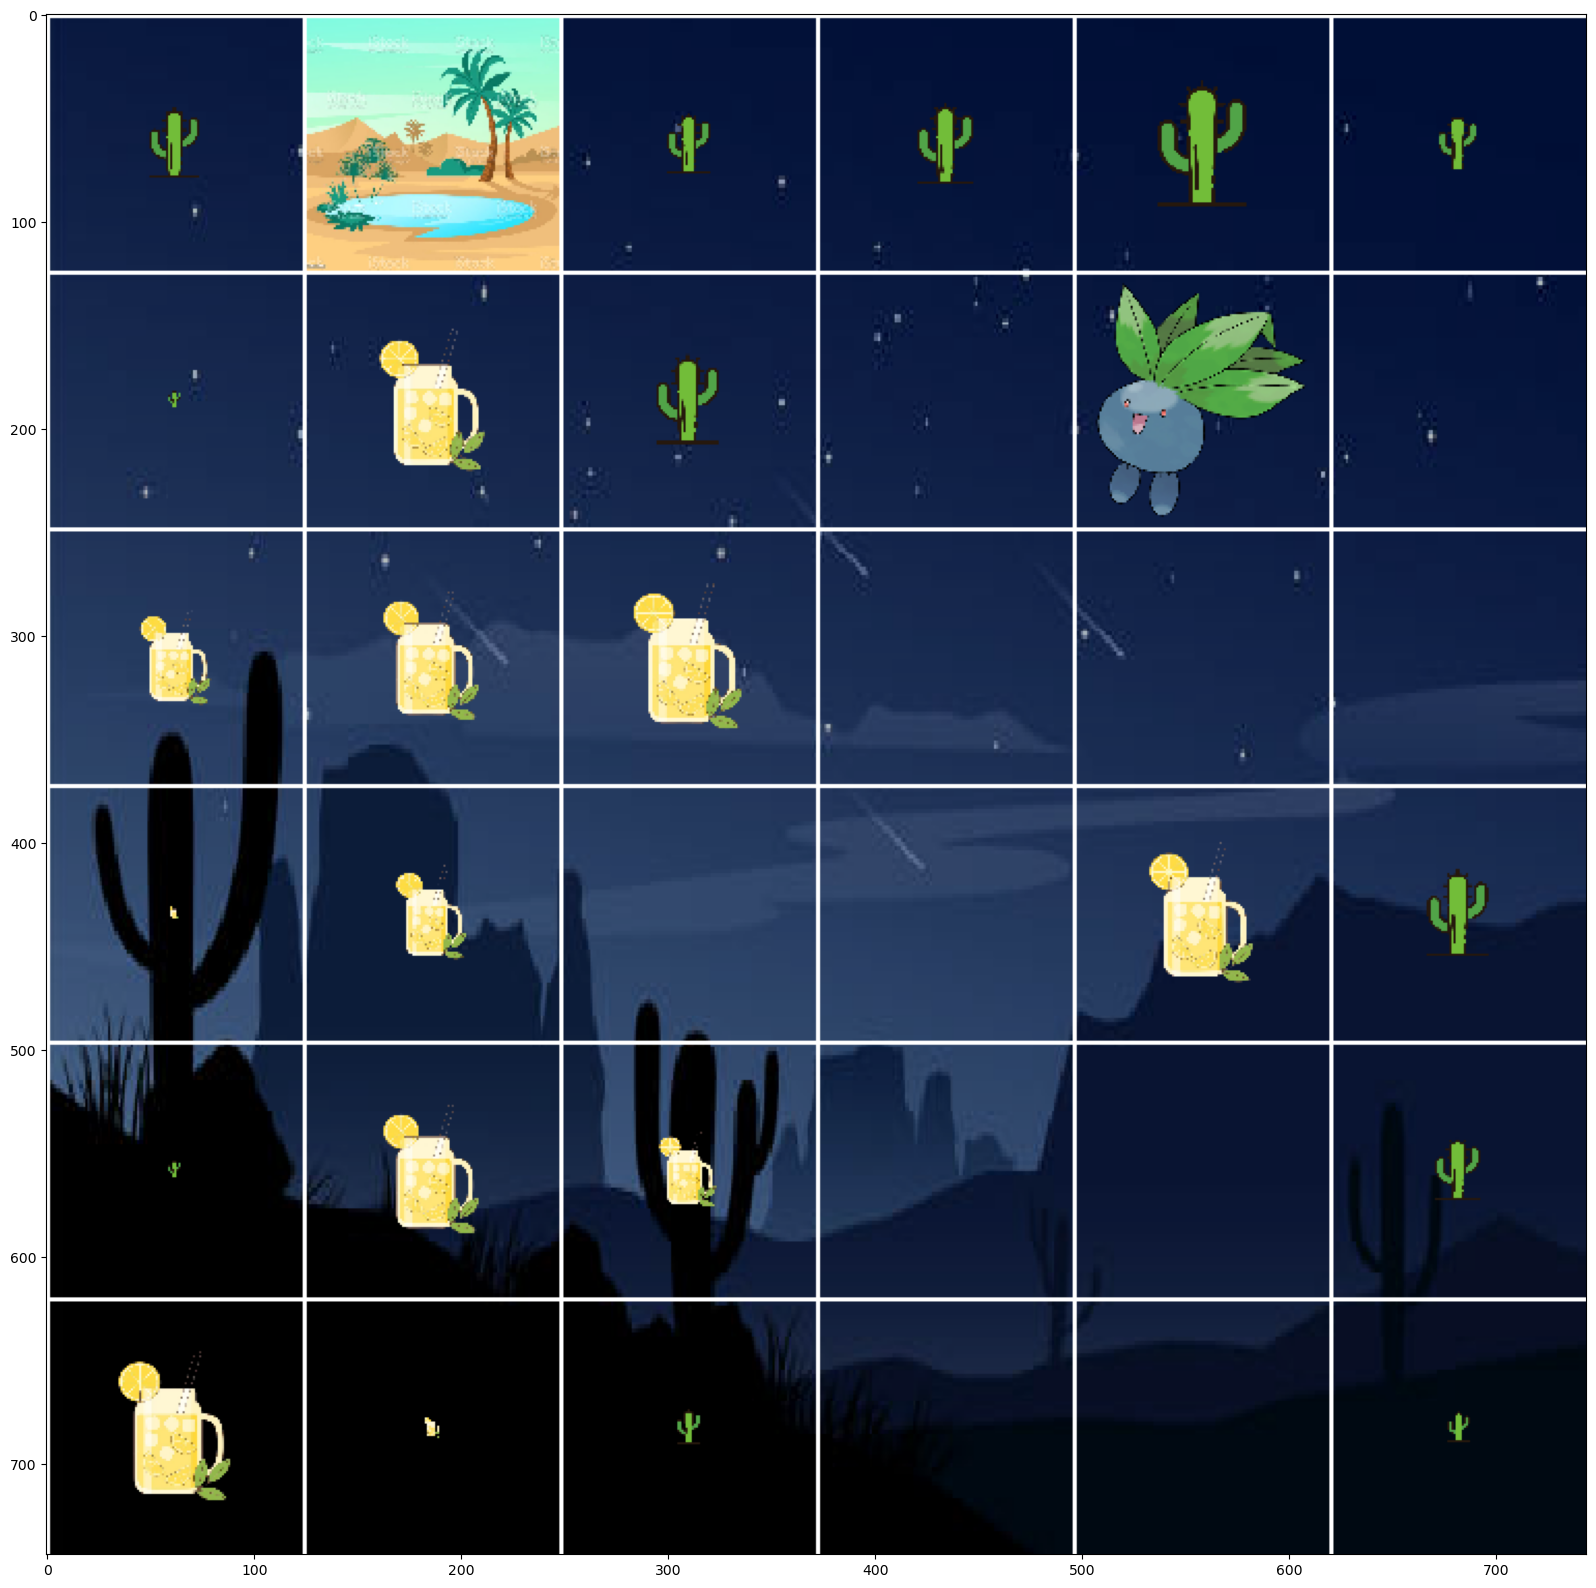

In [12]:
plt.rcParams["figure.figsize"] = (20,20)

obs, info = denv.reset(88)

terminated, truncated = False, False

plt.imshow(denv.render())
plt.show()

history = [obs]
while not (terminated or truncated):
  action = agent.step(obs)
  obs, reward, terminated, truncated, info = denv.step(action)

  clear_output(wait=True)
  plt.imshow(denv.render())
  plt.show()

  history.append((obs, reward))
  time.sleep(1)


In [13]:
# End the simulation
for item in history:
    print(item)

senv.close()

{'agent': array([4, 4]), 'goal': array([0, 1])}
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, -0.44)
({'agent': array([4, 4]), 'goal': array([0, 1]), 'action': 'up'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([5, 4]), 'goal': array([0, 1]), 'action': 'down'}, 0.0)
({'agent': array([4, 4]), 'goal': array([0, 1]), 'action': 'up'}, 0.0)
({'agent': array([4, 3]), 'goal': array([0, 1]), 'action': 'left'}, -0.48)
({'agent': array([3, 3]), 'goal': array([0, 1]), 'action': 'up'}, -0.38)
({'agent': array([3, 2]), 'goal': array([0, 1]), 'action': 'left'}, 0.29)
({'agent': array([3, 3]), 'goal': array([0, 1]), 'action': 'right'}, 0.0)
({'agent': array([2, 3]), 'goal': array([0, 1]), 'action': 'up'}, -0.51)
({'agent': array([2, 4]), 'goal': array([0, 1]), 'action': 'right'}, 0.01)
({'agent': array([2, 3]), 'goal': array([0, 1]), 'action': 'left'}, 0.0)
({'agent': array([1, 3]), 'goal': array([0, 1]), 'action': 'up'}, 0.1)
(